https://machineboxio.com/docs/facebox/teaching-facebox -> followed this and posted the Lennon image which is wqhy it is recognised below

https://www.home-assistant.io/components/image_processing/

192.168.1.24 is NAS

Teaching requires a `file` be posted, whilst checking requires `base64 encoded string`

In [6]:
import requests
import operator
import os
import io
import base64
import pathlib
from PIL import Image
import json
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import sys
print(sys.version)

HEADERS = {'content-type': 'application/json'} ; # charset=utf-8
IP = "localhost" # "192.168.1.24"
PORT = "8080"
CLASSIFIER = 'facebox'
CHECK_URL = "http://{}:{}/facebox/check".format(IP, PORT)
print(CHECK_URL)

FIG_SIZE = (12, 8)
ATTR_NAME = 'name'
ATTR_CONFIDENCE = 'confidence'
ATTR_ENTITY_ID = 'entity_id'
VALID_ENTITY_ID = 'image_processing.facebox_demo_camera'
VALID_FILETYPES = ('.jpg', '.png', '.jpeg')

ATTR_BOUNDING_BOX = 'bounding_box'
ATTR_IMAGE_ID = 'image_id'
ATTR_MATCHED = 'matched'

CONF_USERNAME = 'my_username'
CONF_PASSWORD = 'my_password'

HTTP_UNAUTHORIZED = 401

def print_json(json_data):
    PrettyPrinter().pprint(json_data)

3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
http://localhost:8080/facebox/check


In [2]:
# Up to date functions from the Facebox HA component 

def encode_image(image):
    """base64 encode an image stream."""
    base64_img = base64.b64encode(image).decode('ascii')
    return base64_img


def get_matched_faces(faces):
    """Return the name and rounded confidence of matched faces."""
    return {face['name']: round(face['confidence'], 2)
            for face in faces if face['matched']}


def parse_faces(api_faces):
    """Parse the API face data into the format required."""
    known_faces = []
    for entry in api_faces:
        face = {}
        if entry['matched']:  # This data is only in matched faces.
            face[ATTR_NAME] = entry['name']
            face[ATTR_IMAGE_ID] = entry['id']
        else:  # Lets be explicit.
            face[ATTR_NAME] = None
            face[ATTR_IMAGE_ID] = None
        face[ATTR_CONFIDENCE] = round(100.0*entry['confidence'], 2)
        face[ATTR_MATCHED] = entry['matched']
        face[ATTR_BOUNDING_BOX] = entry['rect']
        known_faces.append(face)
    return known_faces

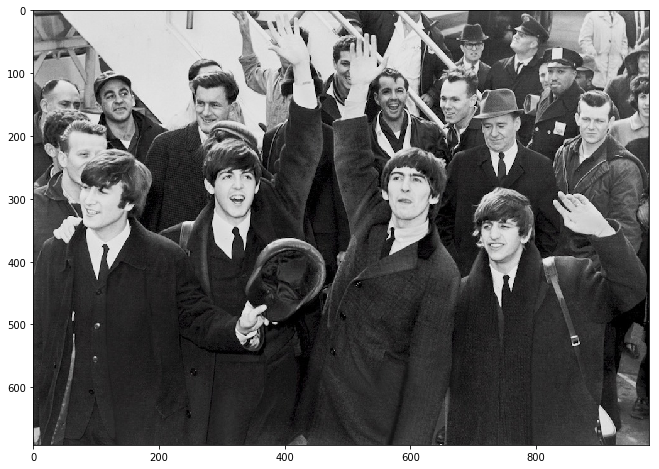

In [3]:
# This notebook assumes you have trained Facebox with the beatles data.

IMG_FILE = "thebeatles.jpg"

img = plt.imread(IMG_FILE)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

## Process an image

In [9]:
%%time
file = {
    'file': (IMG_FILE, open(IMG_FILE, 'rb')),
}

AUTH = requests.auth.HTTPBasicAuth(CONF_USERNAME, CONF_PASSWORD)
response = requests.post(CHECK_URL, files=file, auth=AUTH)
print(response)

<Response [200]>
CPU times: user 3.74 ms, sys: 3.2 ms, total: 6.94 ms
Wall time: 4.24 s


In [5]:
response_json = response.json()

In [6]:
response_json['facesCount']

12

The face data is returned as a list of dict:

In [19]:
response['faces'][5:7]

[{'rect': {'top': 166, 'left': 866, 'width': 43, 'height': 43},
  'matched': False,
  'confidence': 0},
 {'rect': {'top': 253, 'left': 563, 'width': 63, 'height': 62},
  'matched': False,
  'confidence': 0}]

Now we use our convenience functions (from the HA component) to parse the API data

In [7]:
faces = parse_faces(response['faces'])
faces[5:7]

[{'name': None,
  'image_id': None,
  'confidence': 0.0,
  'matched': False,
  'bounding_box': {'top': 166, 'left': 866, 'width': 43, 'height': 43}},
 {'name': None,
  'image_id': None,
  'confidence': 0.0,
  'matched': False,
  'bounding_box': {'top': 253, 'left': 563, 'width': 63, 'height': 62}}]

We can neatly display this on the HA front end by using a dict with {name: confidence} form

In [8]:
get_matched_faces(faces)

{}

## JSON encode image to send
In HA we base64 encode the binary image data and post.

In [6]:
with io.BytesIO() as output:
    with Image.open(IMG_FILE) as img:
        img.save(output, 'BMP')
    data = output.getvalue() # data is a bytes object.

In [7]:
response = requests.post(CHECK_URL, 
                         json={"base64": encode_image(data)},
                         timeout=9).json()

In [8]:
print_json(response['success'])

True


In [11]:
faces = parse_faces(response['faces'])
faces[5:7]

[{'name': None,
  'image_id': None,
  'confidence': 0.0,
  'matched': False,
  'bounding_box': {'top': 166, 'left': 866, 'height': 43, 'width': 43}},
 {'name': None,
  'image_id': None,
  'confidence': 0.0,
  'matched': False,
  'bounding_box': {'top': 253, 'left': 563, 'height': 62, 'width': 63}}]

In [13]:
def post_image(url, image, username, password):
    """Post an image to the classifier."""
    kwargs = {}
    if username:
        kwargs['auth'] = requests.auth.HTTPBasicAuth(username, password)
    try:
        response = requests.post(
            url,
            json={"base64": encode_image(image)},
            **kwargs
            )
        if response.status_code == HTTP_UNAUTHORIZED:
            print("AuthenticationError on %s", CLASSIFIER)
            return None
        return response
    except requests.exceptions.ConnectionError:
        print("ConnectionError: Is %s running?", CLASSIFIER)

In [17]:
requests.auth.HTTPBasicAuth(CONF_USERNAME, CONF_PASSWORD)

In [11]:
kwargs = post_image(CHECK_URL, img, CONF_USERNAME, CONF_PASSWORD)

In [12]:
kwargs = {}
if username:
    kwargs['auth'] = requests.auth.HTTPBasicAuth(username, password)

<Response [400]>

In [8]:
auth = requests.auth.HTTPBasicAuth(CONF_USERNAME, CONF_PASSWORD)

In [16]:
username = CONF_USERNAME
username = None
if username:
    print(username)
else:
    print('No username')

No username


## Teaching
https://machineboxio.com/docs/facebox/teaching-facebox

Can teach using cURL:
```
curl -H 'Content-Type: application/json' -d '{"url":"https://machinebox.io/samples/faces/john.jpg","name":"John Lennon","id":"john.jpg"}' http://localhost:8080/facebox/teach
```

Have a library for teaching with a python script:
    
    https://github.com/robmarkcole/facebox_python
    
We use the approach from the script here. Lets use superman images as in [the blog post](https://towardsdatascience.com/every-superheros-secret-identity-wouldn-t-fool-modern-face-recognition-32c6fda07bb9). 

In [12]:
ls

LICENSE            custom_components/ facebox.png        tests/
README.md          development.ipynb  superman_1.jpeg    thebeatles.jpg
boxed_image.png    docs/              superman_2.jpeg    usage.png


In [7]:
TEACH_URL = "http://{}:{}/{}/teach".format(IP, PORT, CLASSIFIER)
TEACH_URL

'http://localhost:8080/facebox/teach'

In [8]:
def valid_file_path(file_path):
    """Check that a file_path points to a valid file."""
    if not os.access(file_path, os.R_OK):
        print("Could not read file: %s", file_path)
        return False
    else:
        return True

In [9]:
def valid_image(file_path):
    """Check that a file_path points to an image."""
    if file_path.endswith(VALID_FILETYPES):
        return True
    else:
        print("Not a valid image file path: %s", file_path)
        return False

In [16]:
def teach_name_by_file(name, file_path):
    """Teach facebox a single name using a single file."""
    if valid_file_path(file_path) and valid_image(file_path):
        data = {'name': name, "id": file_path}
        file = {'file': open(file_path, 'rb')}
        response = requests.post(TEACH_URL, data=data, files=file)
        print(response.status_code)
        print(response.text)

        if response.status_code == 200:
            print("File:{} taught with name:{}".format(file_path, name))
            return True

        elif response.status_code == 400:
            print("Teaching of file:{} failed with message:{}".format(
                file_path, response.text))
            return False

In [18]:
IMG_FILE = 'superman_1.jpeg'
IMG_FILE = '/Users/robincole/Pictures/kettle.jpg' # Test an image that shouldnt work

teach_name_by_file(name='superman', file_path=IMG_FILE)

400
no faces detected
Teaching of file:/Users/robincole/Pictures/kettle.jpg failed with message:no faces detected


False

Lets check that the second image is correctly identified

In [45]:
IMG_FILE = 'superman_2.jpeg'
file = {
    'file': (IMG_FILE, open(IMG_FILE, 'rb')),
}

response = requests.post(CHECK_URL, files=file)#.json()
response
#response['facesCount']

<Response [500]>

In [19]:
parse_faces(response['faces'])

[{'name': 'superman',
  'image_id': '/Users/robincole/.homeassistant/images/superman_1.jpeg',
  'confidence': 55.63,
  'matched': True,
  'bounding_box': {'top': 64, 'left': 442, 'width': 155, 'height': 155}}]

# Bounding boxes
Some code to show how to save a bounding box over an image.

In [20]:
%%time
IMG_FILE = "thebeatles.jpg"
file = {
    'file': (IMG_FILE, open(IMG_FILE, 'rb')),
}

response = requests.post(URL, files=file).json()

CPU times: user 3.97 ms, sys: 2.38 ms, total: 6.35 ms
Wall time: 4.05 s


In [21]:
def get_bounding_boxes(response):
    """Return the bounding boxes of faces."""
    bounding_boxes = []
    for face in response['faces']:
        bounding_boxes.append(face['rect'])
    return bounding_boxes

In [22]:
bounding_boxes = get_bounding_boxes(response)
bounding_boxes

[{'top': 124, 'left': 636, 'width': 52, 'height': 52},
 {'top': 129, 'left': 246, 'width': 62, 'height': 62},
 {'top': 164, 'left': 711, 'width': 52, 'height': 52},
 {'top': 118, 'left': 106, 'width': 52, 'height': 52},
 {'top': 118, 'left': 549, 'width': 43, 'height': 43},
 {'top': 166, 'left': 866, 'width': 43, 'height': 43},
 {'top': 253, 'left': 563, 'width': 63, 'height': 62},
 {'top': 246, 'left': 287, 'width': 74, 'height': 74},
 {'top': 204, 'left': 55, 'width': 74, 'height': 75},
 {'top': 262, 'left': 63, 'width': 74, 'height': 75},
 {'top': 322, 'left': 709, 'width': 62, 'height': 62},
 {'top': 78, 'left': 803, 'width': 52, 'height': 52}]

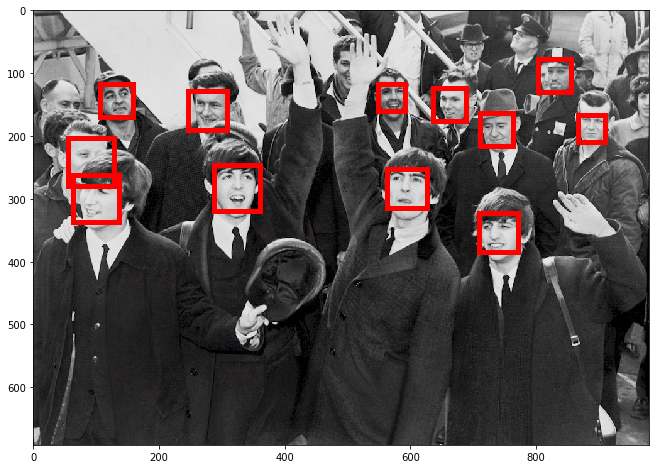

In [23]:
img = plt.imread(IMG_FILE)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

for box in bounding_boxes:
    x = box['left']
    y = box['top']
    width = box['width']
    height = box['height']

    rect = patches.Rectangle((x,y), width, height, linewidth=5, edgecolor='r', facecolor='none')
    ax.add_patch(rect);

plt.savefig('facebox.png')

In [24]:
def save_boxes_image(img_file, bounding_boxes):
    """Take an image file and dict of bounding boxes and save the boxes on a copy of the image."""
    img = plt.imread(img_file)
    fig, ax = plt.subplots()
    ax.imshow(img);
    for box in bounding_boxes:
        x = box['left']
        y = box['top']
        width = box['width']
        height = box['height']

        rect = patches.Rectangle((x,y), width, height, linewidth=5, edgecolor='r', facecolor='none')
        ax.add_patch(rect);

    plt.savefig("boxed_image.png")

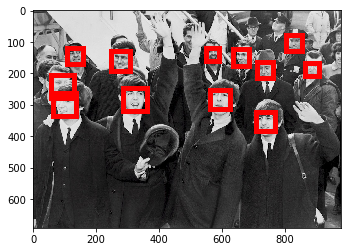

In [25]:
save_boxes_image(IMG_FILE, bounding_boxes)

# Testing

In [26]:
MOCK_FACE = {'confidence': 0.5812028911604818,
             'id': 'john.jpg',
             'matched': True,
             'name': 'John Lennon',
             'rect': {'height': 75, 'left': 63, 'top': 262, 'width': 74}
             }

In [27]:
100.0*round(MOCK_FACE['confidence'], 4)

58.120000000000005

In [28]:
100.0*round(0.5812028911604818, 4)

58.120000000000005

In [29]:
round(100*0.5812028911604818, 2)

58.12

In [30]:
test = {"entry": True}

In [31]:
if test["foo"]:
    print('true')

KeyError: 'foo'

In [ ]:
test.json()

In [32]:
not False

True

In [50]:
def chec_logic():
    if (not True or not True):
        print(True)
        return
    print(False)

In [51]:
chec_logic()

False


In [52]:
not True

False

In [53]:
(False or False)

False

In [54]:
(False or True)

True

In [60]:
(False or False)

False

# Auth

In [ ]:
kwargs = {}

if username:
    kwargs['auth'] = requests.auth.HTTPBasicAuth(username, password)

response = request.post(url, **kwargs)